In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from tqdm.notebook import tqdm
from sim_modules.misc import zoom_fft_correct_phase
from sim_modules.pupils import AberratedPupil3D, PupilType
from sim_modules.aperture import Aperture, IMG_MODE
from sim_modules.plottings import (
    AXIAL_FREQ_LABEL,
    HORIZONTAL_COS_LABEL,
    AXIAL_LABEL,
    HORIZONTAL_LABEL,
    VERTICAL_LABEL,
    PSF_AMP_LABEL,
    WAVELENGTH,
    WAVELENGTH_LEGEND,
    LOCATION_X,
    LOCATION_Y,
    LOCATION_Z,
    LOCATION_XY,
    CTF_AMP_LABEL,
    plot_2Dpupil,
    plot_3Dpupil,
    plot_wavefronterror,
    plot_ctf_xz_reim,
    plot_ctf_xz_amppha,
    plot_ctf_yz_reim,
    plot_ctf_yz_amppha,
    plot_ctf_xy_reim,
    plot_ctf_xy_amppha,
    psf_unit,
    ctf_unit,
    swap,
    swap_supaxes,
)

In [ ]:
def center_of_range(input: NDArray, axis: int) -> NDArray:
    """Center of the range of the input array along the specified axis.

    Parameters
    ----------
    input : NDArray
        Input array.
    axis : int
        Axis along which to center the range.

    Returns
    -------
    NDArray
        Array with centered range along the specified axis.
    """
    out = ((
        np.max(input, axis=axis) +
        np.min(input, axis=axis)
    ) / 2.0)
    return out

In [ ]:
plt.rcParams['text.usetex'] = True

In [ ]:
# Transpose PSF plots or not.
# If True, axial direction is vertical, otherwise horizontal.
TRANSPOSE = False

In [ ]:
# Imaging mode
img_mode = IMG_MODE.PSFD
# img_mode = IMG_MODE.LF
# img_mode = IMG_MODE.SCFF

In [ ]:
# Refractive index of the surrounding medium
# nb = 1.0  # Refractive index of air
nb = 1.34  # Refractive index of tissue

In [ ]:
# Select simulation mode

SIM_MODE = 'CTF_zoom'  # Calculate the coherent transfer function with zoom FFT
# SIM_MODE = 'CTF'  # Calculate the coherent transfer function

In [ ]:
# Flag normalization of pupils
NORMALIZE = True

In [ ]:
# Flag imaging mode
TRANSMISSION = False

In [ ]:
# Flag paraxial propagation
PARAXIAL = False  # Simulation with paraxial propagation

In [ ]:
# Spectral dimension

λ = [0.95, 1.04, 1.15]
# λ = [1.04]
# λ = [0.8, 0.85, 0.9]
k_num = len(λ)
k = 2 * np.pi / np.asarray(λ, dtype=np.float32)
kc = k[len(k) // 2]

# in tissue
kb = k * nb
kbc = kc * nb

print("Central wavelength [um]: {}".format(2 * np.pi / kc))

Central wavelength [um]: 1.0399999047610027


In [ ]:
# Wavefront aberration parameters
# NOTE: The wavefront aberration simulation is now available for the same cut-off NA and
# the shared optical path between the illumination and collection.
#
# If the paths are shared but have different cutoff NAs, scaling of the Zernike expansion would be necessary.
#
# In the case of the different optical path, the wavefront aberration should be defined separately.

ns = [(2, 2), (3, 1), (4, 0)]  # Zernike expansion orders
coeff = [(0.2, -0.05), (0.04, -0.032), -0.1]  # Zernike expansion coefficients (RMS) [µm]

In [ ]:
# Calculate RMS wavefront error
rms = 0
for cos in coeff:
    for co in (cos if isinstance(cos, tuple) else (cos,)):
        rms += co ** 2
rms = np.sqrt(rms)
print("RMS wavefront error [µm]: {}".format(rms))

RMS wavefront error [µm]: 0.23478500803926985


In [ ]:
# Chromatic aberrations
Δx = 0.0  # Transversal chromatic focal shift per wavenumber [µm · µm]
Δz = 0.0  # Longitudinal chromatic focal shift per wavenumber [µm · µm]

ca = (Δx, 0, Δz)

In [ ]:
# Define pupils. Numerical apertures (NAs) are in air.
if img_mode == IMG_MODE.SCFF:
    na_co_ill = 0.0
    na_w_ill = 0.0
else:
    # pupil_ill = AberratedPupil3D(PupilType.CIRC, 0.988, ns, coeff, ca=ca, kc=kbc)
    pupil_ill = AberratedPupil3D(PupilType.GAUSS, 0.25, ns, coeff, na_w=0.2, ca=ca, kc=kbc)

# pupil_col = AberratedPupil3D(PupilType.CIRC, 0.479, ns, coeff, ca=ca, kc=kbc)
pupil_col = AberratedPupil3D(PupilType.GAUSS, 0.25, ns, coeff, na_w=0.2, ca=ca, kc=kbc)

In [ ]:
pupil_col.reverse = TRANSMISSION

In [ ]:
# Pupil coordinates
νpx_num = 257
# νpx_num = 501

if np.isscalar(pupil_ill.na_co):
    na_co_ill_max = pupil_ill.na_co
else:
    na_co_ill_max = max(pupil_ill.na_co)

if np.isscalar(pupil_col.na_co):
    na_co_col_max = pupil_col.na_co
else:
    na_co_col_max = max(pupil_col.na_co)

νx_max = (kb.max() / (2 * np.pi)) * max(na_co_ill_max, na_co_col_max)
νpx, νpy = np.meshgrid(
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    indexing='xy'
)

dνx = dνy = νpx[0, 1] - νpx[0, 0]

In [ ]:
# Spatial frequency coordinates for the illumination pupil
match img_mode:
    case IMG_MODE.PSFD:
        νx_ill = νpx
        νy_ill = νpy
    case IMG_MODE.LF:
        νx_ill = νpx[None, 0]
        νy_ill = np.zeros_like(νx_ill)

In [ ]:
# Pupil coordinates for the central wavelength
σxc_ill = - 2 * np.pi * νx_ill / kbc
σyc_ill = - 2 * np.pi * νy_ill / kbc
σxc_col = - 2 * np.pi * νpx / kbc
σyc_col = - 2 * np.pi * νpy / kbc

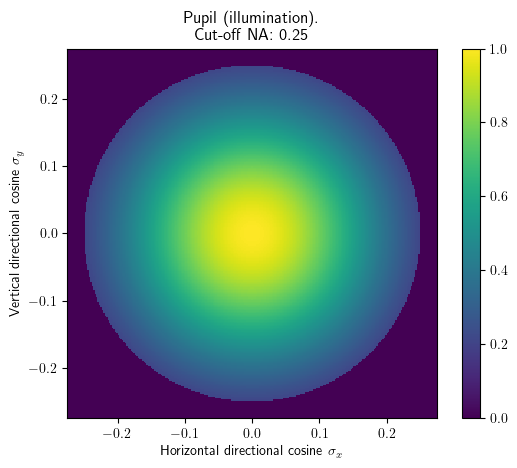

In [ ]:
# 2D plot of the illumination pupil
match img_mode:
    case IMG_MODE.SCFF:
        pass
    case IMG_MODE.LF:
        P = pupil_ill.pupil2D(σxc_ill, σyc_ill)
        plt.figure()
        plt.plot(σxc_ill[0], P[0])
        plt.title(
            "Pupil (illumination).\n"
            "Cut-off NA: {}".format(
                pupil_ill.na_co
            )
        )
        plt.xlabel(HORIZONTAL_COS_LABEL)
        plt.show()
    case IMG_MODE.PSFD:
        plot_2Dpupil(
            pupil_ill,
            σxc_ill,
            σyc_ill,
            'illumination'
        )

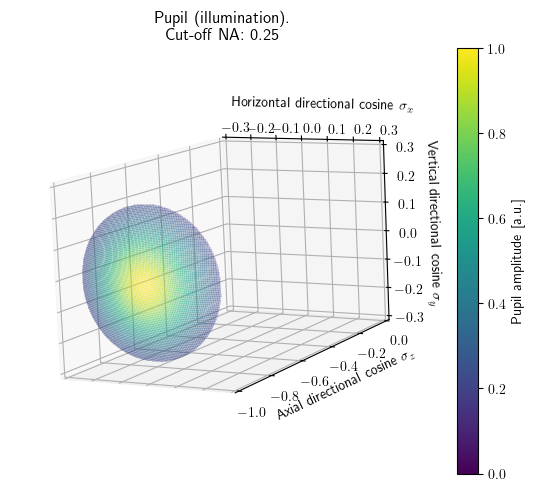

In [ ]:
# 3D surface plot of the illumination pupil
if img_mode == IMG_MODE.PSFD:
    plot_3Dpupil(
        pupil_ill,
        σxc_ill,
        σyc_ill,
        'illumination'
    )

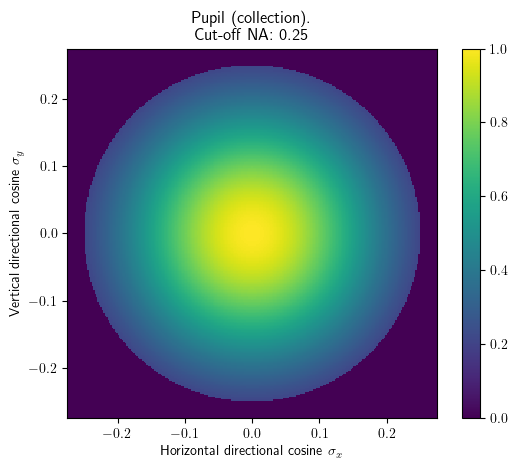

In [ ]:
# 2D plot of the collection pupil

plot_2Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

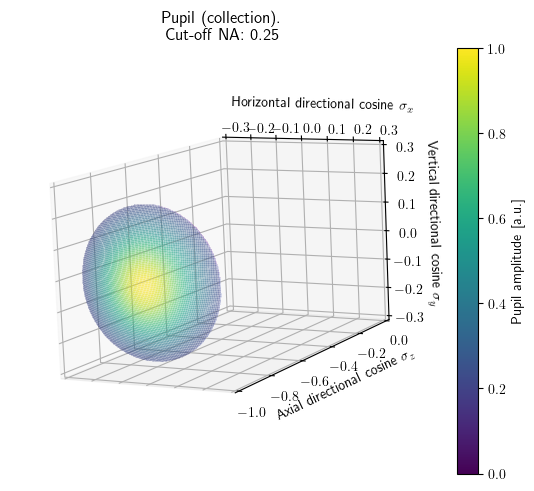

In [ ]:
# 3D surface plot of the collection pupil
plot_3Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

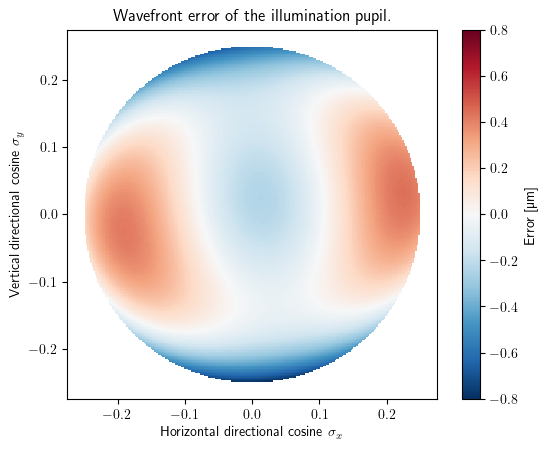

In [ ]:
# 2D plot of wavefront error in illumination pupil
match img_mode:
    case IMG_MODE.SCFF:
        pass
    case IMG_MODE.LF:
        pupil_ill.set_wavefront_error(σxc_ill, σyc_ill)
        W_ill = pupil_ill.we
        plt.figure()
        plt.plot(σxc_ill[0], W_ill[0])
        plt.title("Wavefront error of the illumination pupil.")
        plt.xlabel(HORIZONTAL_COS_LABEL)
        plt.show()
    case IMG_MODE.PSFD:
        plot_wavefronterror(
            pupil_ill,
            σxc_ill,
            σyc_ill,
            'illumination'
        )

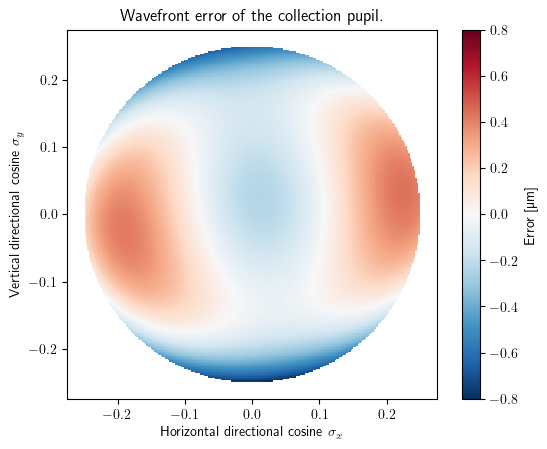

In [ ]:
# 2D plot of wavefront error in collection pupil
plot_wavefronterror(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

In [ ]:
# Spatial coordinate
match img_mode:
    case IMG_MODE.SCFF:
        νx_num = νpx_num
        νy_num = νpx_num
    case IMG_MODE.PSFD:
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num * 2 - 1  # Doubled to take into account convolution
    case IMG_MODE.LF:
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num
y = sp.fft.fftshift(sp.fft.fftfreq(νy_num, (νpy[1, 0] - νpy[0, 0])))
x = sp.fft.fftshift(sp.fft.fftfreq(νx_num, (νpx[0, 1] - νpx[0, 0])))

print(x.max() - x.min())

362.2784914591879


In [ ]:
# Spatial frequency cordinate
νx = sp.fft.fftshift(sp.fft.fftfreq(νx_num, 1 / (νx_num * (νpx[0, 1] - νpx[0, 0]))))
νy = sp.fft.fftshift(sp.fft.fftfreq(νy_num, 1 / (νy_num * (νpy[1, 0] - νpy[0, 0]))))

ν_xx, ν_yy = np.meshgrid(
    νx, νy,
    indexing='xy'
)

In [ ]:
# Rough estimation of the Rayleigh length
if img_mode == IMG_MODE.SCFF:
    z_r = 4 / (na_co_col_max ** 2 * kbc)
else:
    z_r = np.sqrt(
        4 / (max(na_co_ill_max, na_co_col_max) ** 2 * kbc)
    )

z_r

2.8116697171933547

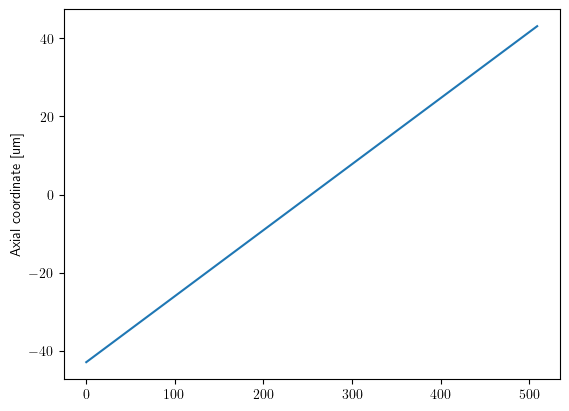

In [ ]:
# Axial location
z_step = 2 * np.pi / (4.2 * kb.max())
z_num = 10.0 * z_r / z_step + 1
if z_num < 256:
    z_num = 256
zs_r = np.arange(start=0,
                 stop=z_num * z_step,
                 step=z_step,
                 dtype=np.float32)
if SIM_MODE.endswith('zoom'):
    # Smooth continuous axial coordinate for zoom FFT.
    z = np.concatenate((-zs_r[-2:0:-1], zs_r))
else:
    # Make the first element as z = 0
    z = np.concatenate((zs_r, -zs_r[-2:0:-1]))
idx_z0 = np.where(z == 0)[0][0]

plt.figure()
plt.plot(z)
plt.ylabel("Axial coordinate [um]")
plt.show()

In [ ]:
# Initialize, allocate memory

h_tilde = np.zeros((νy_num, νx_num) + z.shape + k.shape, dtype=np.complex64)

ill_amp = np.zeros(k.shape, dtype=np.float32)
col_amp = np.zeros(k.shape, dtype=np.float32)

f_zp_ill = np.zeros(z.shape + k.shape, dtype=np.complex64)
f_zp_col = np.zeros(z.shape + k.shape, dtype=np.complex64)

aperture = Aperture(pupil_ill, pupil_col, img_mode)

h_tilde.nbytes / 1024 ** 2

3071.964797973633

In [ ]:
for i, kb_i in enumerate(tqdm(kb, desc="Wavenumber")):

    h_tilde[..., i] = aperture(
        (νx_ill, νy_ill),
        (νpx, νpy),
        kb_i, z, NORMALIZE, idx_z0=idx_z0, PARAXIAL=PARAXIAL
    )

    if NORMALIZE:
        ill_amp[i] = aperture.ill_amp
        col_amp[i] = aperture.col_amp

    f_zp_ill[..., i] = np.nansum(
        aperture.ftilde_ill, axis=(0, 1)
    )
    match img_mode:
        case IMG_MODE.SCFF:
            pass
        case IMG_MODE.LF:
            f_zp_ill[..., i] *= dνx
        case IMG_MODE.PSFD:
            f_zp_ill[..., i] *= dνx * dνy
    f_zp_col[..., i] = np.nansum(
        aperture.ftilde_col, axis=(0, 1)
    ) * dνx * dνy

Wavenumber:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Phase shift along the axial coordinate
if TRANSMISSION:
    a = np.exp(1.0j * kb[None, :] * z[:, None])
    b = np.exp(-1.0j * kb[None, :] * z[:, None])
else:
    a = np.exp(1.0j * kb[None, :] * z[:, None])
    b = np.exp(1.0j * kb[None, :] * z[:, None])

In [ ]:
# Set the axial frequency coordinate range

if TRANSMISSION:
    νz12 = [
        - kb.max() / (2 * np.pi) * (1 - np.sqrt(1 - max(na_co_ill_max, na_co_ill_max) ** 2)),
        kb.max() / (2 * np.pi) * (1 - np.sqrt(1 - max(na_co_ill_max, na_co_ill_max) ** 2))
    ]
else:
    νz12 = [
        - 2 * kb.max() / (2 * np.pi),
        - kb.min() / (2 * np.pi) * (
            np.sqrt(1 - na_co_ill_max ** 2) +
            np.sqrt(1 - na_co_col_max ** 2)
        )
    ]
# νz12 = [-2 * kb.max() / (2 * np.pi), 0]
# νz12 = [kb.min() / (2 * np.pi) * np.sqrt(1 - na_co_ill_max ** 2),
#         # kb.min() / (2 * np.pi) * np.sqrt(1 - na_co_col_max ** 2),
#         kb.max() / (2 * np.pi)]

if SIM_MODE.endswith('zoom'):
    νzm = int(np.round((νz12[1] - νz12[0]) / dνx)) + 1
    νz12[1] = νz12[0] + dνx * (νzm - 1)

In [ ]:
# coherent transfer function
ki = 1

dz = z[1] - z[0]

if SIM_MODE.endswith('zoom'):

    νz = np.linspace(νz12[0], νz12[1], num=νzm, endpoint=True)

    H = zoom_fft_correct_phase(
        h_tilde[..., ki],
        νz12,
        z[0],
        fs=1/dz,
        m=νzm,
        endpoint=True
    ) * dz
else:
    H = sp.fft.fftshift(sp.fft.fft(h_tilde[..., ki]), axes=-1) * dz
    νz = sp.fft.fftshift(sp.fft.fftfreq(z.size, dz))

print(λ[ki])

1.04


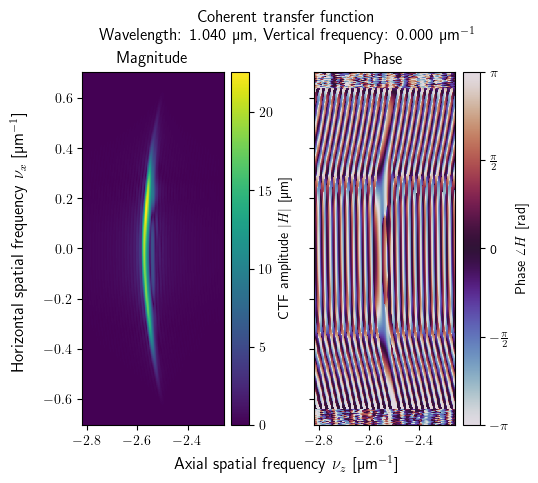

In [ ]:
plot_ctf_xz_amppha(H, νx, νy, νz, νy_num // 2, λ[ki], NORMALIZE, img_mode, νz12, Hmax=None,
                   TRANSPOSE=TRANSPOSE)

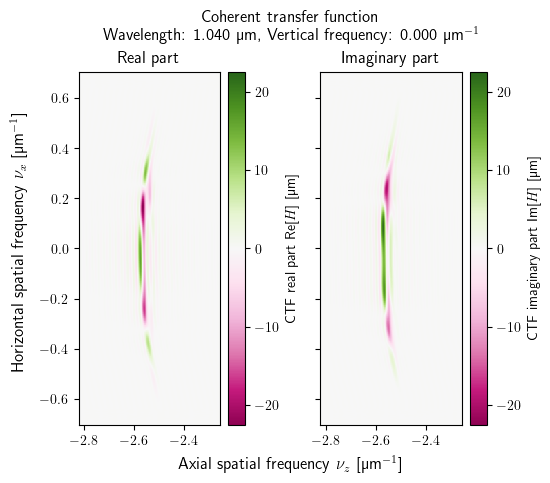

In [ ]:
plot_ctf_xz_reim(H, νx, νy, νz, νy_num // 2, λ[ki], NORMALIZE, img_mode, νz12, Hmax=None,
                 TRANSPOSE=TRANSPOSE)

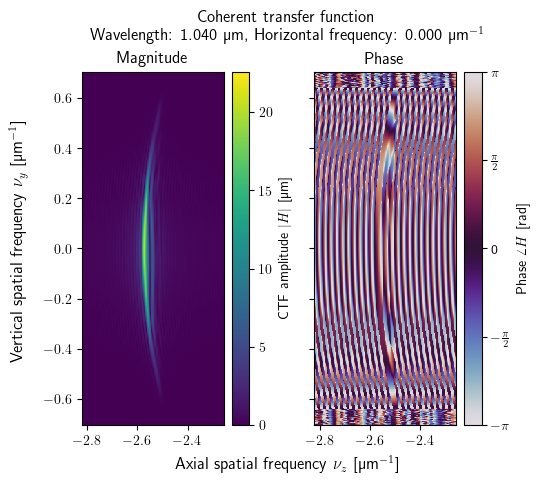

In [ ]:
plot_ctf_yz_amppha(H, νx, νy, νz, νx_num // 2, λ[ki], NORMALIZE, img_mode, Hmax=None,
                   TRANSPOSE=TRANSPOSE)

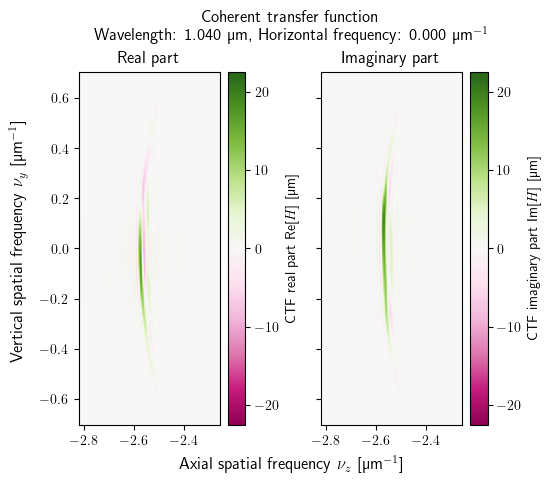

In [ ]:
plot_ctf_yz_reim(H, νx, νy, νz, νx_num // 2, λ[ki], NORMALIZE, img_mode, νz12, Hmax=None,
                 TRANSPOSE=TRANSPOSE)

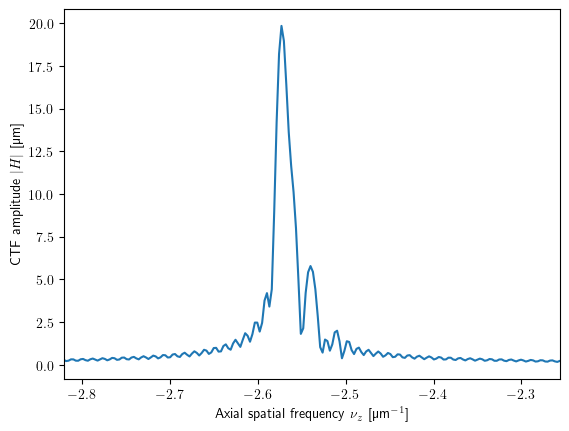

In [ ]:
plt.figure()
plt.plot(νz, np.abs(H[νy_num // 2, νx_num // 2, :]))
plt.xlim(νz12[0], νz12[1])
plt.xlabel(AXIAL_FREQ_LABEL)
plt.ylabel(CTF_AMP_LABEL + ctf_unit(NORMALIZE and img_mode == IMG_MODE.PSFD))
plt.show()

In [ ]:
idx_νz = np.argmax(np.abs(H[νy_num // 2, νx_num // 2, :]))

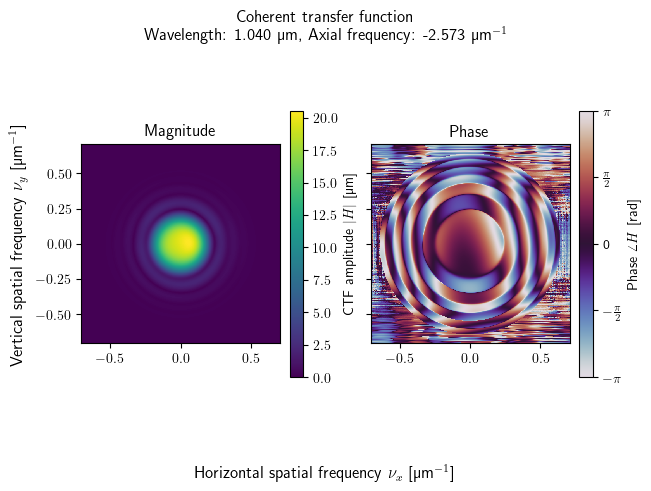

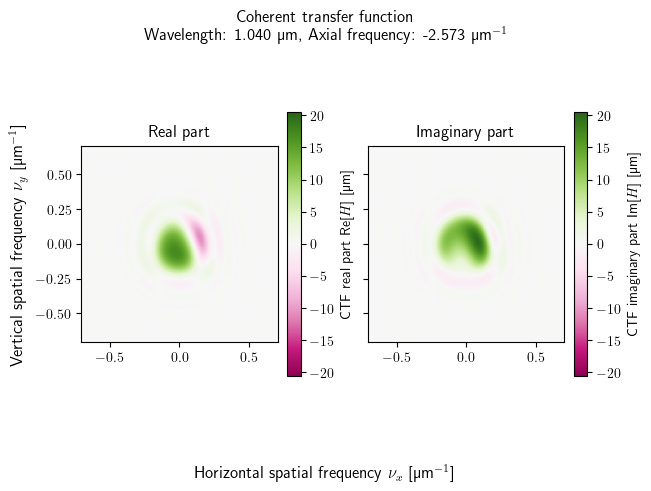

In [ ]:
plot_ctf_xy_amppha(H, νx, νy, νz, idx_νz, λ[ki], NORMALIZE, img_mode)
plot_ctf_xy_reim(H, νx, νy, νz, idx_νz, λ[ki], NORMALIZE, img_mode)

In [ ]:
# PSF

In [ ]:
x12 = [-20.0, 20.0]
xd_num = 129
xd = np.linspace(x12[0], x12[1], num=xd_num, endpoint=True)

ht = zoom_fft_correct_phase(
    zoom_fft_correct_phase(
        h_tilde[..., ki],
        x12, νx[0],
        fs=1/dνx, m=xd_num, axis=1
    ) * dνx,
    x12, νy[0],
    fs=1/dνy, m=xd_num, axis=0
) * dνy

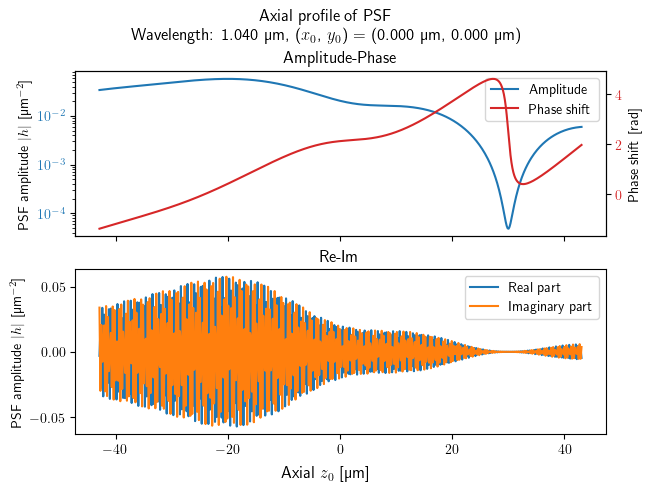

In [ ]:
# Axial profile

fig, (ax_amppha, ax_reim) = plt.subplots(2, 1, sharex='all', layout='compressed')

color = 'tab:blue'
lns1 = ax_amppha.semilogy(
    np.sort(z),
    np.abs(ht[xd_num // 2, xd_num // 2, np.argsort(z)]),
    color=color,
    label="Amplitude",
)
ax_amppha.set_ylabel(PSF_AMP_LABEL + psf_unit(NORMALIZE and img_mode == IMG_MODE.PSFD))
ax_amppha.tick_params(axis='y', labelcolor=color)
ax_amppha.set_title("Amplitude-Phase")

ax_pha = ax_amppha.twinx()

color = 'tab:red'
lns2 = ax_pha.plot(
    np.sort(z),
    np.unwrap(
        np.angle(ht[xd_num // 2, xd_num // 2, :] * a[:, ki] * b[:, ki]
                 )[np.argsort(z)],
    ),
    color=color,
    label="Phase shift",
)
ax_pha.set_ylabel("Phase shift [rad]")
ax_pha.tick_params(axis='y', labelcolor=color)

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax_amppha.legend(lns, labs)


ax_reim.plot(
    np.sort(z),
    np.real(ht[xd_num // 2, xd_num // 2, np.argsort(z)]),
    label="Real part",
)
ax_reim.plot(
    np.sort(z),
    np.imag(ht[xd_num // 2, xd_num // 2, np.argsort(z)]),
    label="Imaginary part",
)
ax_reim.set_ylabel(PSF_AMP_LABEL + psf_unit(NORMALIZE and img_mode == IMG_MODE.PSFD))
ax_reim.set_title("Re-Im")
ax_reim.legend()

fig.supxlabel(AXIAL_LABEL)
fig.suptitle(
    ("Axial profile of PSF\n" +
     WAVELENGTH + ", " + LOCATION_XY).format(
         λ[ki], xd[xd_num // 2], xd[xd_num // 2]))

plt.show()

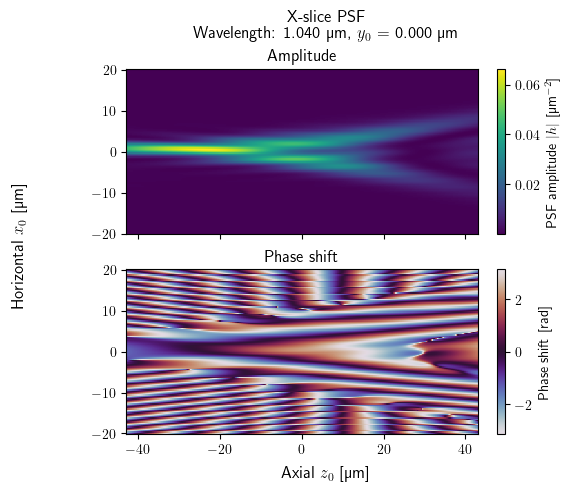

In [ ]:
# XZ plot

fig, (ax_amp, ax_pha) = plt.subplots(
    *swap(2, 1, TRANSPOSE),
    sharex='all', sharey='all', layout='compressed'
)

pcm_amp = ax_amp.pcolormesh(
    *swap(np.sort(z), xd, TRANSPOSE),
    np.abs(
        np.transpose(
            np.take_along_axis(
                ht[xd_num // 2],
                np.argsort(z)[None, :], axis=-1
            ),
            (1, 0) if TRANSPOSE else (0, 1)
        ),
    )
)
fig.colorbar(pcm_amp, label=PSF_AMP_LABEL + psf_unit(NORMALIZE and img_mode == IMG_MODE.PSFD))
ax_amp.set_aspect('equal')
ax_amp.set_title("Amplitude")

pcm_pha = ax_pha.pcolormesh(
    *swap(np.sort(z), xd, TRANSPOSE),
    np.angle(
        np.transpose(
            np.take_along_axis(
                ht[xd_num // 2] * a[None, :, ki] * b[None, :, ki],
                np.argsort(z)[None, :],
                axis=-1
            ),
            (1, 0) if TRANSPOSE else (0, 1)
        )
    ),
    cmap='twilight', vmin=-np.pi, vmax=np.pi
)
fig.colorbar(pcm_pha, label="Phase shift [rad]")
ax_pha.set_aspect('equal')
ax_pha.set_title("Phase shift")

fig.supxlabel(AXIAL_LABEL)
fig.supylabel(HORIZONTAL_LABEL)
fig.suptitle(
    ("X-slice PSF\n" +
     WAVELENGTH + ", " + LOCATION_Y).format(λ[ki], xd[xd_num // 2])
)
if TRANSPOSE:
    swap_supaxes(fig)

plt.show()

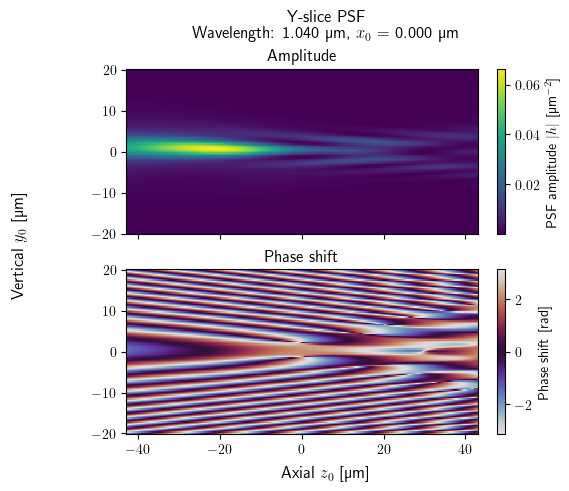

In [ ]:
# YZ plot

fig, (ax_amp, ax_pha) = plt.subplots(
    *swap(2, 1, TRANSPOSE),
    sharex='all', sharey='all', layout='compressed'
)

pcm_amp = ax_amp.pcolormesh(
    *swap(np.sort(z), xd, TRANSPOSE),
    np.abs(
        np.transpose(
            np.take_along_axis(ht[:, xd_num // 2], np.argsort(z)[None, :], axis=-1),
            (1, 0) if TRANSPOSE else (0, 1)
        ),
    ),
)
fig.colorbar(pcm_amp, label=PSF_AMP_LABEL + psf_unit(NORMALIZE and img_mode == IMG_MODE.PSFD))
ax_amp.set_aspect('equal')
ax_amp.set_title("Amplitude")

pcm_pha = ax_pha.pcolormesh(
    *swap(np.sort(z), xd, TRANSPOSE),
    np.angle(
        np.transpose(
            np.take_along_axis(
                ht[:, xd_num // 2] * a[None, :, ki] * b[None, :, ki],
                np.argsort(z)[None, :],
                axis=-1
            ),
            (1, 0) if TRANSPOSE else (0, 1)
        )
    ),
    cmap='twilight', vmin=-np.pi, vmax=np.pi
)
fig.colorbar(pcm_pha, label="Phase shift [rad]")
ax_pha.set_aspect('equal')
ax_pha.set_title("Phase shift")

fig.supxlabel(AXIAL_LABEL)
fig.supylabel(VERTICAL_LABEL)
fig.suptitle(
    ("Y-slice PSF\n" +
     WAVELENGTH + ", " + LOCATION_X).format(λ[ki], xd[xd_num // 2])
)
if TRANSPOSE:
    swap_supaxes(fig)

plt.show()

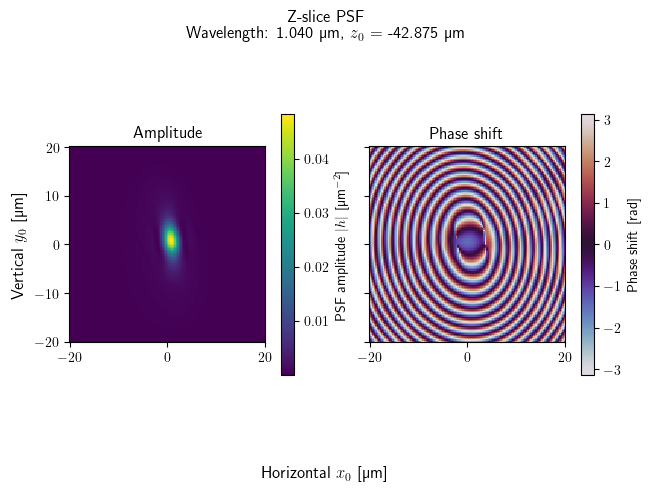

In [ ]:
# XY plot
z_i = 0
# z_i = idx_z0

fig, (ax_amp, ax_pha) = plt.subplots(1, 2, sharex='all', sharey='all', layout='compressed')
pcm_amp = ax_amp.pcolormesh(
    xd, xd,
    np.abs(ht[..., z_i]),
)
fig.colorbar(pcm_amp, label=PSF_AMP_LABEL + psf_unit(NORMALIZE and img_mode == IMG_MODE.PSFD))
ax_amp.set_aspect('equal')
ax_amp.set_title("Amplitude")

pcm_pha = ax_pha.pcolormesh(
    xd, xd,
    np.angle(ht[..., z_i] * a[z_i, ki] * b[z_i, ki]),
    cmap='twilight', vmin=-np.pi, vmax=np.pi
)
fig.colorbar(pcm_pha, label="Phase shift [rad]")
ax_pha.set_aspect('equal')
ax_pha.set_title("Phase shift")

fig.supxlabel(HORIZONTAL_LABEL)
fig.supylabel(VERTICAL_LABEL)
fig.suptitle(
    ("Z-slice PSF\n" +
     WAVELENGTH + ", " + LOCATION_Z).format(λ[ki], z[z_i])
)

plt.show()